# GAN model generating images of human faces

### GAN model refers to Generative Adversarial Network which contains two neural network models to be trained against each other. The first neural network is named generator to generate fake samples and the second one is named discriminator to differentiate fake sample from the real ones.

![](GAN.png)

### CelebA dataset is used here for the traing. Following shows what the data look like.

![](celeface.png)

### Define a class containing both generator and discriminator and optimazation of both. 

In [20]:
class Model:

    def __init__(self, image_batch, g_input_z):
        self.image_batch = image_batch
        self.g_input_z = g_input_z

        with tf.variable_scope("generator"):
            self.g_output = self.generator()
        self.gparams = tf.trainable_variables()

        with tf.variable_scope("discriminator"):
            self.D1 = self.discriminator(self.image_batch)
        with tf.variable_scope("discriminator", reuse = True):
            self.D2 = self.discriminator(self.g_output)
        self.dparams = [v for v in tf.trainable_variables() if v.name.startswith('discriminator')]

        # Declare losses, optimizers(trainers) and fid for evaluation
        self.g_loss = self.g_loss_function()
        self.d_loss = self.d_loss_function()
        self.g_train = self.g_trainer()
        self.d_train = self.d_trainer()
        self.fid = self.fid_function()

    def discriminator(self, x):
        """Compute discriminator score for a batch of input images.
        
        Inputs:
        - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
        
        Returns:
        TensorFlow Tensor with shape [batch_size, 1], containing the score 
        for an image being real for each input image.
        """
        
        dlayer1 = layers.conv2d(x, 64, [5,5],strides = [2,2],padding = 'SAME',activation = tf.nn.leaky_relu)
        dlayer2 = layers.conv2d(dlayer1, 128, [5,5],strides = [2,2],padding = 'SAME',activation = tf.nn.leaky_relu)
        dlayer2 = layers.batch_normalization(dlayer2,axis = 3)
        dlayer3 = layers.conv2d(dlayer2, 256, [5,5],strides = [2,2],padding = 'SAME',activation = tf.nn.leaky_relu)
        dlayer3 = layers.batch_normalization(dlayer3,axis = 3)
        dlayer4 = layers.conv2d(dlayer3, 512, [5,5],strides = [2,2],padding = 'SAME',activation = tf.nn.leaky_relu)
        dlayer4 = layers.batch_normalization(dlayer4,axis = 3)
        dlayer4 =  tf.reshape(dlayer4,[dlayer4.shape[0],512*4*4])
        dlayer5 = layers.dense(dlayer4, 1, activation = tf.nn.sigmoid)
        return dlayer5


    def generator(self):
        """Generate images from a random noise vector.
        
        Inputs:
        - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
        
        Returns:
        TensorFlow Tensor of generated images, with shape [batch_size, 784].
        """
        glayer1 = layers.dense(self.g_input_z, 512*16,activation = tf.nn.relu)
        glayer1 = tf.reshape(glayer1, [self.g_input_z.shape[0], 4,4,512])
        glayer1 = layers.batch_normalization(glayer1,axis = 3)
        glayer2 = layers.conv2d_transpose(glayer1, 256,[5,5], strides = [2,2],padding = 'SAME', activation = tf.nn.relu)
        glayer2 = layers.batch_normalization(glayer2,axis = 3)
        glayer3 = layers.conv2d_transpose(glayer2,128,[5,5], strides = [2,2],padding = 'SAME', activation = tf.nn.relu)
        glayer3 = layers.batch_normalization(glayer3,axis = 3)
        glayer4 = layers.conv2d_transpose(glayer3,64,[5,5], strides = [2,2],padding = 'SAME', activation = tf.nn.relu)
        glayer4 = layers.batch_normalization(glayer4,axis = 3)
        glayer5 = layers.conv2d_transpose(glayer4,3,[5,5], strides = [2,2],padding = 'SAME', activation = tf.tanh)
        
        return glayer5

    # Training loss for Generator
    def g_loss_function(self):
        g_loss = tf.reduce_mean(-log(self.D2)) 
        return g_loss

    # Training loss for Discriminator
    def d_loss_function(self):
        d_loss = 0.5*tf.reduce_mean(-log(self.D1)-log(1- self.D2)) 
        return d_loss

    # Optimizer/Trainer for Generator
    def g_trainer(self):
        g_train = tf.train.AdamOptimizer(args.learn_rate, args.beta1).minimize(self.g_loss, var_list = self.gparams) 
        return g_train

    # Optimizer/Trainer for Discriminator
    def d_trainer(self):
        d_train = tf.train.AdamOptimizer(args.learn_rate, args.beta1).minimize(self.d_loss, var_list = self.dparams) 
        return d_train

### After training of 7 epochs, Frechet Inception Distance (FID) between generated image and the real image is below 350. The generated images are shown below.

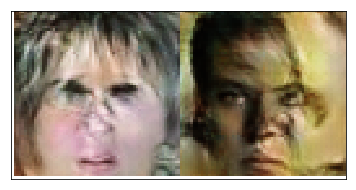

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("output.png")
plt.imshow(image)
plt.imshow(image).axes.get_xaxis().set_visible(False)
plt.imshow(image).axes.get_yaxis().set_visible(False)
plt.show()

### The outputs do not look like real faces because of the limited training epochs. But the results clearly contains the basic feature of a face and further training would certainly improve the results.